### Project 5 - EDA and all analysis 
### Kristie Kooken

Code for final project submission

In [1]:
# loading libraries 

import numpy as np
import pandas as pd

import scipy.stats
from scipy.stats import chi2_contingency
import statistics 

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sklearn

from sklearn.linear_model import Ridge
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel

###Model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,\
roc_auc_score

import imblearn
from imblearn.over_sampling import SMOTE

##### Reading in the data

In [2]:
# Get the data.
# 1 importing the mlb data 

lt = pd.read_csv('risk_factors_cervical_cancer.csv')

In [3]:
lt.head(1)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
lt.shape

(858, 36)

# Data Cleaning 

In [5]:
# creating counts of the character variables in order to see what is causing the variable to be interpreted as an object
f2 = lt.select_dtypes(include=['object'])

In [6]:
b = f2.columns.tolist()
type(b)

list

In [7]:
for i in b:
    j = lt[i].value_counts()
    print(i)
    print(j)

Number of sexual partners
2.0     272
3.0     208
1.0     206
4.0      78
5.0      44
?        26
6.0       9
7.0       7
8.0       4
15.0      1
10.0      1
28.0      1
9.0       1
Name: Number of sexual partners, dtype: int64
First sexual intercourse
15.0    163
17.0    151
18.0    137
16.0    121
14.0     79
19.0     60
20.0     37
13.0     25
21.0     20
23.0      9
22.0      9
?         7
26.0      7
12.0      6
27.0      6
24.0      6
29.0      5
28.0      3
11.0      2
25.0      2
10.0      2
32.0      1
Name: First sexual intercourse, dtype: int64
Num of pregnancies
1.0     270
2.0     240
3.0     139
4.0      74
?        56
5.0      35
6.0      18
0.0      16
7.0       6
8.0       2
11.0      1
10.0      1
Name: Num of pregnancies, dtype: int64
Smokes
0.0    722
1.0    123
?       13
Name: Smokes, dtype: int64
Smokes (years)
0.0            722
1.266972909     15
?               13
5.0              9
9.0              9
1.0              8
3.0              7
2.0              7
16

In [8]:
# cleaning up the ? values - using the median for the first three values 
# Using mode to replace missing data 
medreplace = pd.to_numeric(lt['Number of sexual partners'].replace(['?'], '')).median()
medreplace

2.0

In [9]:
lt['Number of sexual partners'] = pd.to_numeric(lt['Number of sexual partners'].replace(['?'], medreplace))

In [10]:
medrepl2 = pd.to_numeric(lt['First sexual intercourse'].replace(['?'], '')).median()
medrepl2

17.0

In [11]:
lt['First sexual intercourse'] = pd.to_numeric(lt['First sexual intercourse'].replace(['?'], medrepl2))

In [12]:
medrepl3 = pd.to_numeric(lt['Num of pregnancies'].replace(['?'], '')).median()
medrepl3

2.0

In [13]:
lt['Num of pregnancies'] = pd.to_numeric(lt['Num of pregnancies'].replace(['?'], medrepl3))

In [14]:
# creating a list to loop through columns that will replace ? with zero, making the assumption that any missing value
# will mean the subject did not use what was being questions or have a time since first/last

zlist = ['Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', \
 'IUD', 'IUD (years)','STDs: Time since first diagnosis', 'STDs: Time since last diagnosis']

In [15]:
# replacing ? with zero 
for j in zlist:
    lt[j] = pd.to_numeric(lt[j].replace(['?'], '0'))

In [16]:
# after investigating these data points, the same number of subjects did not answer this section
# I decided to replace ? values with the occuring value. It is noted that may be no different than the above code
# however, I investigated this population as a separate effort

# initially I considered dropping these records however, there is a cancer diagnosis and I felt that it was 
# important not to remove based on that since having a cancer diagnosis is not a common event 

stdlist = ['STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', \
 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', \
 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', \
 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV' ]

In [17]:
# replace ? with missing
for j in stdlist:
    lt[j] = pd.to_numeric(lt[j].replace(['?'], ''))

In [18]:
# replace missing with zero 
for i in stdlist:
    lt[i].fillna(value=lt[i].value_counts().index[0],inplace =True)

In [19]:
lt.shape

(858, 36)

Inspection of the resulting dataframe confirmed that data was scrubbed as expected. 

In [20]:
# Dx & Dx: CIN are dropped - I do not know what Dx is and Dx: CIN I did not identify this as part of the scope to have 
# as a target, only Dx: Cancer and Dx: HPV are the targets that I am investigating. 

# Also DX has no documentation on what it is. 

lt = lt.drop(['Dx', 'Dx:CIN'], axis=1)

In [21]:
# continuous column list 
b = ['Age','Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies',
      'Smokes (years)', 'Smokes (packs/year)', 
      'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)', 
      'STDs: Number of diagnosis', 'STDs: Time since first diagnosis',
      'STDs: Time since last diagnosis']

In [22]:
# creating continous only dataframe for use below 
# taking out diochotomous columns like Smokes, IUD, STDs, 'Dx:Cancer', 
#'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy' etc for this descriptive stats and 
# correlation matrix 

lt3 = lt.drop(['Smokes',  'Hormonal Contraceptives','IUD','STDs','STDs:condylomatosis', 
               'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis','STDs:syphilis',
               'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 
               'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV','STDs:cervical condylomatosis', 'STDs:AIDS',
               'Dx:Cancer', 'Dx:HPV',  'Hinselmann', 'Schiller', 'Citology', 'Biopsy'], axis=1)

In [23]:
# dichotomous column list
b3 = [ 'Smokes',  'Hormonal Contraceptives','IUD','STDs','STDs:condylomatosis', 'STDs:vaginal condylomatosis', 
      'STDs:vulvo-perineal condylomatosis',
      'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 
      'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
      'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']

In [24]:
# creating a dichotomous only data frame for use below 

ltdic = lt[['Smokes',  'Hormonal Contraceptives','IUD','STDs','STDs:condylomatosis', 'STDs:vaginal condylomatosis', 
      'STDs:vulvo-perineal condylomatosis',
      'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 
      'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
      'Hinselmann', 'Schiller', 'Citology', 'Biopsy','Dx:Cancer', 'Dx:HPV']]


#### Histograms and Barcharts and Descriptive Statistics were run and checked to ensure no outliers were present and to view the distributions. 

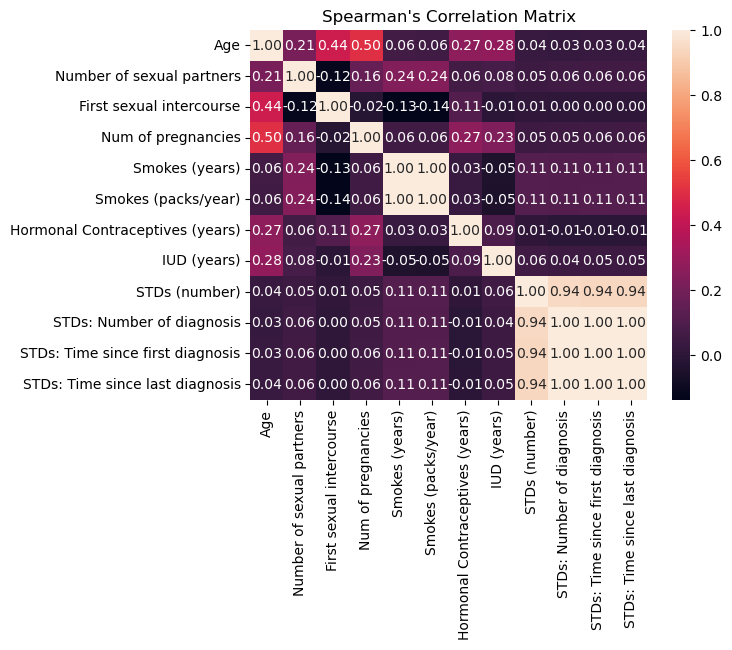

In [25]:
# correlation matrix - spearman is used because the distributions are skewed for the continuous variables 
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
sns.heatmap(lt3.corr(method = 'spearman'), annot = True, fmt = '.2f')
plt.title("Spearman's Correlation Matrix");

In [26]:
# based on the results of the correlation maxtrix STDs: Time since the first diagnosis / STDs: Time since last diagnosis
# have a strong correlation thus I will drop STDs: Time since the first diagnosis

ltf = lt.drop(['STDs: Number of diagnosis', 'STDs: Time since first diagnosis','STDs: Time since last diagnosis',
               'Smokes (packs/year)'], axis=1)

In [27]:
# it is important to understand the relationship between the two targets
cross = pd.crosstab(ltf["Dx:Cancer"], ltf["Dx:HPV"])

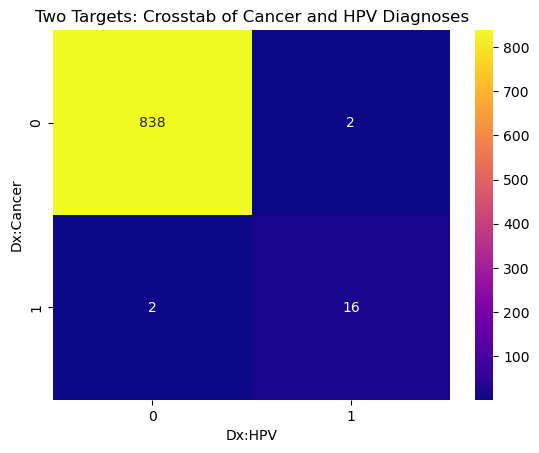

In [28]:
# this is an important visualization of the relationship between the two targets
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
sns.heatmap(cross, cmap= 'plasma', annot=True, fmt='g')
plt.title ("Two Targets: Crosstab of Cancer and HPV Diagnoses");

In [29]:
# relationship between the two target variables 
chi2, p, dof, ex = chi2_contingency(pd.crosstab(ltf["Dx:Cancer"], ltf["Dx:HPV"]))
p

2.0016351973050176e-139

# Split into train and test sets 

In [30]:
# I am creating 2 df for predicting each target - all screening variables will be present in each 
# starting with model for Dx of Cancer thus dropping off other target
X = ltf[['Age', 'Number of sexual partners', 'First sexual intercourse', 
'Num of pregnancies', 'Smokes', 'Smokes (years)',  
'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 
'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 
'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 
'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 
'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']]

In [31]:
Y = ltf[['Dx:Cancer']]

In [32]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y['Dx:Cancer'], random_state=42)

In [33]:
y_train.groupby(['Dx:Cancer'])['Dx:Cancer'].count()

Dx:Cancer
0    630
1     13
Name: Dx:Cancer, dtype: int64

In [34]:
y_test.groupby(['Dx:Cancer'])['Dx:Cancer'].count()

Dx:Cancer
0    210
1      5
Name: Dx:Cancer, dtype: int64

In [35]:
# make a copy of the data
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()

In [36]:
contlst = ['Age','Number of sexual partners','First sexual intercourse', 
        'Num of pregnancies','Smokes (years)', 
        'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']

### Scaling the data

In [37]:
X_train_trans[contlst] = X_train_trans[contlst].astype(float)
X_test_trans[contlst] = X_test_trans[contlst].astype(float)

In [38]:
#Scaling is necessary because many machine learning algorithms use distance-based calculations, 
#and they can be sensitive to the scale of the input features. Failing to scale continuous data 
#can lead to suboptimal model performance or even incorrect predictions

#Min-Max Scaling (Normalization): because i have different ranges and want to  
#preserve the original distribution of the data.

scaler = MinMaxScaler()
#X_train_minmax = scaler.fit_transform(X_train)
X_train_trans[contlst] = scaler.fit_transform(X_train_trans[contlst])
X_test_trans[contlst] = scaler.transform(X_test_trans[contlst])
X_train_trans.shape, X_test_trans.shape

((643, 28), (215, 28))

In [39]:
# small to see if what is expected happened
X_train_trans.head(1)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),...,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Hinselmann,Schiller,Citology,Biopsy
716,0.084507,0.142857,0.263158,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


### Logistic regression - dummy classifier 

In [40]:
# running models without any features removed
# stratified class dummy classifier
#The most frequent and stratified classifiers are useful for imbalanced datasets, 
#but the stratified classifier is more useful as it ensures that the model is not biased toward the majority class. 
ostratified_dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
ostratified_dummy_clf.fit(X_train_trans, y_train)
ostratified_dummy_pred = ostratified_dummy_clf.predict(X_test_trans)

### Logistic regression - all features 

In [41]:
# Logistic regression classifier
ologreg_clf = LogisticRegression()
ologreg_clf.fit(X_train_trans, y_train.values.ravel())
ologreg_pred = ologreg_clf.predict(X_test_trans)

In [42]:
# print the r2 value 
print("Dummy Classifier: ", ostratified_dummy_clf.score(X_train_trans, y_train.values.ravel()))
print("Logisitic Classifier: ", ologreg_clf.score(X_train_trans, y_train.values.ravel()))

Dummy Classifier:  0.9642301710730948
Logisitic Classifier:  0.9797822706065319


In [43]:
# looking at the confusion matrix for this model
tn, fp, fn, tp = confusion_matrix(y_test, ologreg_pred).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  210 
False positives:  0 
False negatives:  5 
True positives:  0


In [44]:
# Print classification reports
print("\nClassification Report (Stratified Dummy Classifier):")
print(classification_report(y_test, ostratified_dummy_pred, zero_division=0))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, ologreg_pred, zero_division=0))


Classification Report (Stratified Dummy Classifier):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       210
           1       0.00      0.00      0.00         5

    accuracy                           0.97       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.97      0.96       215


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       210
           1       0.00      0.00      0.00         5

    accuracy                           0.98       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.98      0.97       215



### Feature Selection

In [45]:
# Using LASSO for feature selection
# why LASSO? because it can reduce features that dont add value to zero so it was chosen 
sel_ = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))
sel_.fit(X_train_trans, np.ravel(y_train))


SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'))

In [46]:
sel_.get_support()

array([False, False, False, False,  True, False,  True, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True])

In [47]:
selected_feat = X_train_trans.columns[(sel_.get_support())]
print('total features: {}'.format((X_train_trans.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 28
selected features: 7
features with coefficients shrank to zero: 21


In [48]:
kept_feats = X_train.columns[(sel_.estimator_.coef_ > 0).ravel().tolist()],\
             X_train.columns[(sel_.estimator_.coef_ < 0).ravel().tolist()]
kept_feats

(Index(['Hormonal Contraceptives', 'IUD', 'STDs:HPV', 'Schiller', 'Biopsy'], dtype='object'),
 Index(['Smokes', 'STDs:condylomatosis'], dtype='object'))

In [49]:
X_train_selected = sel_.transform(X_train_trans)
X_test_selected = sel_.transform(X_test_trans)
X_train_selected.shape, X_test_selected.shape

((643, 7), (215, 7))

### Logistic regression - dummy classifier, after feature selection

In [50]:
# stratified class dummy classifier
#The most frequent and stratified classifiers are useful for imbalanced datasets, 
#but the stratified classifier is more useful as it ensures that the model is not biased toward the majority class.

# the purpose of this is to see if removing features helps the model performance 
stratified_dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
stratified_dummy_clf.fit(X_train_selected, y_train)
stratified_dummy_pred = stratified_dummy_clf.predict(X_test_selected)

### Logistic regression - after feature selection

In [51]:
# Logistic regression classifier
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train_selected, y_train.values.ravel())
logreg_pred = logreg_clf.predict(X_test_selected)

In [52]:
# print the r2 value 
print("Dummy Classifier: ", stratified_dummy_clf.score(X_train_selected, y_train.values.ravel()))
print("Logisitic Classifier: ", logreg_clf.score(X_train_selected, y_train.values.ravel()))

Dummy Classifier:  0.9642301710730948
Logisitic Classifier:  0.9797822706065319


In [53]:
# Print classification reports
print("\nClassification Report (Stratified Dummy Classifier):")
print(classification_report(y_test, stratified_dummy_pred, zero_division=0))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, logreg_pred, zero_division=0))


Classification Report (Stratified Dummy Classifier):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       210
           1       0.00      0.00      0.00         5

    accuracy                           0.97       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.97      0.96       215


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       210
           1       0.00      0.00      0.00         5

    accuracy                           0.98       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.98      0.97       215



In [54]:
# looking at the confusion matrix for this model
tn, fp, fn, tp = confusion_matrix(y_test, logreg_pred).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  210 
False positives:  0 
False negatives:  5 
True positives:  0


### SMOTE for Dx:Cancer

In [55]:
# beginning SMOTE section 
yy = y_train.values.ravel()

In [56]:
# summarize class distribution
from collections import Counter
counter = Counter(yy)
print(counter)

Counter({0: 630, 1: 13})


In [57]:
oversample = SMOTE()

In [58]:
#X, y = oversample.fit_resample(X, y)
X_resampled, y_resampled = SMOTE().fit_resample(X_train_selected, y_train.values.ravel())

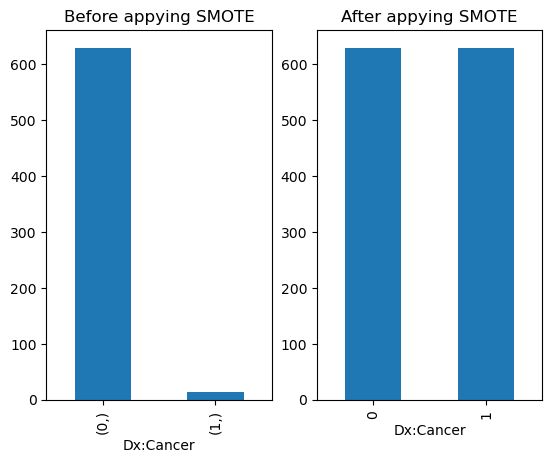

In [59]:
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Before appying SMOTE', xlabel='Dx:Cancer')
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='After appying SMOTE', xlabel='Dx:Cancer')
plt.show();

### Hyperparameter tuning
 

In [60]:
# after SMOTE - configuring the approach to logistic regression 
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [61]:
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_resampled, y_resampled)

In [62]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.840212 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.840212 (0.036064) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.840212 (0.036064) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.840212 (0.036064) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.839153 (0.036423) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839153 (0.036423) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.839153 (0.036423) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.837831 (0.036061) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.837831 (0.036061) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.837566 (0.035831) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.816667 (0.032488) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816667 (0.032488) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.823016 (0.032540) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.805026 (0.034938) wit

In [63]:
# Fit the model with the data that has been resampled with SMOTE & the best settings 
# Logistic regression classifier
log_reg_2 = LogisticRegression(C= 100, penalty= 'l2', solver='newton-cg')
log_reg_2.fit(X_resampled, y_resampled)


LogisticRegression(C=100, solver='newton-cg')

In [64]:
# Predict on the test set (not resampled to obtain honest evaluation)
preds2 = log_reg_2.predict(X_test_selected)

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  185 
False positives:  25 
False negatives:  3 
True positives:  2


Confusion Matrix


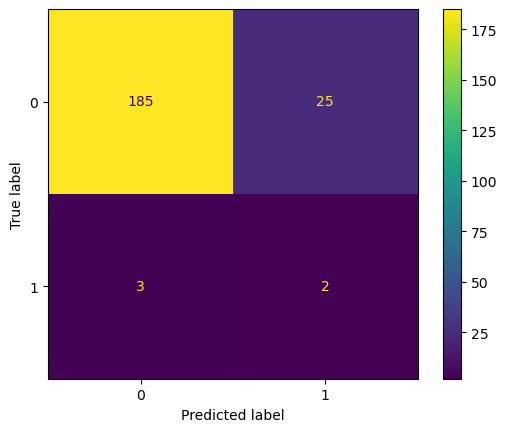

In [66]:
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, preds2);

In [67]:
# print the r2 value 
print("Logisitic Classifier: ", log_reg_2.score(X_resampled, y_resampled))

Logisitic Classifier:  0.8404761904761905


In [68]:
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, preds2, zero_division=0))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       210
           1       0.07      0.40      0.12         5

    accuracy                           0.87       215
   macro avg       0.53      0.64      0.53       215
weighted avg       0.96      0.87      0.91       215



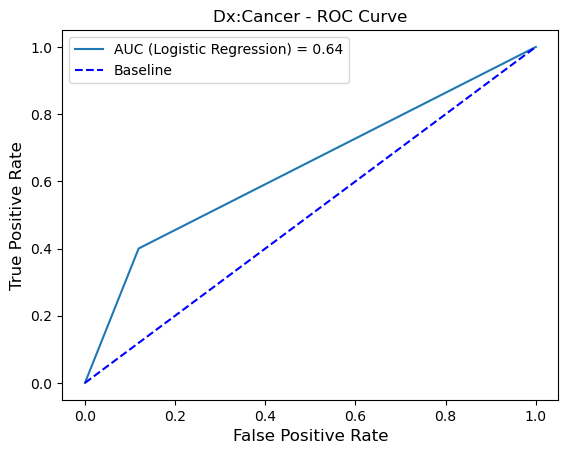

In [69]:
y_test_int = y_test
auc_lr = roc_auc_score(y_test_int, preds2)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_int, preds2)

plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Dx:Cancer - ROC Curve', size=12)
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.legend();

In [70]:
print(log_reg_2.coef_, log_reg_2.intercept_)

[[-6.5609133   1.28618825  2.95651473 -7.84966343 21.61073318  0.2243512
   2.5519395 ]] [-2.04542498]


### Beginning section for Dx:HPV

In [71]:
# beginning analysis for Dx:HPV
Y1 = ltf[['Dx:HPV']]

In [72]:
# Split the data into train and test sets
X_train, X_test, y1_train, y1_test = train_test_split(X, Y1, test_size=0.25, stratify=Y1['Dx:HPV'], random_state=42)

In [73]:
y1_train.groupby(['Dx:HPV'])['Dx:HPV'].count()

Dx:HPV
0    630
1     13
Name: Dx:HPV, dtype: int64

In [74]:
y1_test.groupby(['Dx:HPV'])['Dx:HPV'].count()

Dx:HPV
0    210
1      5
Name: Dx:HPV, dtype: int64

### Dx:HPV Baseline modeling on all features with Dummy Classifier

In [75]:
# running models without any features removed for HPV
# stratified class dummy classifier

ostratified_dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
ostratified_dummy_clf.fit(X_train_trans, y1_train)
ostratified_dummy_pred = ostratified_dummy_clf.predict(X_test_trans)

In [76]:
# Logistic regression classifier
ologreg_clf = LogisticRegression()
ologreg_clf.fit(X_train_trans, y1_train.values.ravel())
ologreg_pred = ologreg_clf.predict(X_test_trans)

In [77]:
# print the r2 value 
print("Dummy Classifier: ", ostratified_dummy_clf.score(X_train_trans, y1_train.values.ravel()))
print("Logisitic Classifier: ", ologreg_clf.score(X_train_trans, y1_train.values.ravel()))

Dummy Classifier:  0.9642301710730948
Logisitic Classifier:  0.9797822706065319


In [78]:
# looking at the confusion matrix for this model
tn, fp, fn, tp = confusion_matrix(y1_test, ologreg_pred).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  210 
False positives:  0 
False negatives:  5 
True positives:  0


In [79]:
# Print classification reports
print("\nClassification Report (Stratified Dummy Classifier):")
print(classification_report(y1_test, ostratified_dummy_pred, zero_division=0))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y1_test, ologreg_pred, zero_division=0))


Classification Report (Stratified Dummy Classifier):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       210
           1       0.00      0.00      0.00         5

    accuracy                           0.97       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.97      0.96       215


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       210
           1       0.00      0.00      0.00         5

    accuracy                           0.98       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.98      0.97       215



### Feature selection for Dx:HPV

In [80]:
# running LASSO for HPV as well 
sel_.fit(X_train_trans, np.ravel(y1_train))

SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'))

In [81]:
sel_.get_support()

array([False, False, False, False,  True, False,  True, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True])

In [82]:
selected_feat = X_train_trans.columns[(sel_.get_support())]
print('total features: {}'.format((X_train_trans.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 28
selected features: 7
features with coefficients shrank to zero: 21


In [83]:
kept_feats = X_train.columns[(sel_.estimator_.coef_ > 0).ravel().tolist()],\
             X_train.columns[(sel_.estimator_.coef_ < 0).ravel().tolist()]
kept_feats

(Index(['Hormonal Contraceptives', 'IUD', 'STDs:HPV', 'Schiller', 'Biopsy'], dtype='object'),
 Index(['Smokes', 'STDs:condylomatosis'], dtype='object'))

In [84]:
X_train_selected = sel_.transform(X_train_trans)
X_test_selected = sel_.transform(X_test_trans)
X_train_selected.shape, X_test_selected.shape

((643, 7), (215, 7))

### Baseline modeling after feature selection for Dx:HPV

In [85]:
# the purpose of this is to see if removing features helps the model performance 
stratified_dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
stratified_dummy_clf.fit(X_train_selected, y1_train)
stratified_dummy_pred = stratified_dummy_clf.predict(X_test_selected)

In [86]:
# Logistic regression classifier
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train_selected, y1_train.values.ravel())
logreg_pred = logreg_clf.predict(X_test_selected)

In [87]:
# print the r2 value 
print("Dummy Classifier: ", stratified_dummy_clf.score(X_train_selected, y1_train.values.ravel()))
print("Logisitic Classifier: ", logreg_clf.score(X_train_selected, y1_train.values.ravel()))

Dummy Classifier:  0.9642301710730948
Logisitic Classifier:  0.9797822706065319


In [88]:
# Print classification reports
print("\nClassification Report (Stratified Dummy Classifier):")
print(classification_report(y1_test, stratified_dummy_pred, zero_division=0))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y1_test, logreg_pred, zero_division=0))


Classification Report (Stratified Dummy Classifier):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       210
           1       0.00      0.00      0.00         5

    accuracy                           0.97       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.97      0.96       215


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       210
           1       0.00      0.00      0.00         5

    accuracy                           0.98       215
   macro avg       0.49      0.50      0.49       215
weighted avg       0.95      0.98      0.97       215



In [89]:
# looking at the confusion matrix for this model
tn, fp, fn, tp = confusion_matrix(y1_test, logreg_pred).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  210 
False positives:  0 
False negatives:  5 
True positives:  0


### SMOTE for Dx:HPV

In [90]:
# beginning SMOTE section 
yy1 = y1_train.values.ravel()

In [91]:
# summarize class distribution

counter = Counter(yy1)
print(counter)

Counter({0: 630, 1: 13})


In [92]:
#X, y = oversample.fit_resample(X, y)
X1_resampled, y1_resampled = SMOTE().fit_resample(X_train_selected, y1_train.values.ravel())

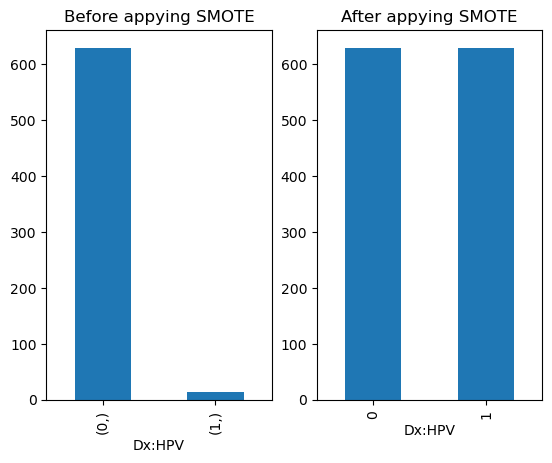

In [93]:
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Before appying SMOTE', xlabel='Dx:HPV')
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='After appying SMOTE', xlabel='Dx:HPV')
plt.show();

### TUNING for Dx:HPV

In [94]:
# tuning for HPV
grid_result = grid_search.fit(X1_resampled, y1_resampled)

In [95]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.841799 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.841799 (0.026476) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.841799 (0.026476) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841799 (0.026476) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.839683 (0.027523) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839683 (0.027523) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.839683 (0.027523) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.832275 (0.026460) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832275 (0.026460) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832275 (0.026854) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.814815 (0.026666) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.814815 (0.026666) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.821693 (0.025736) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.807937 (0.028498) wit

### Final Model for Dx:HPV

In [96]:
# Fit the model with the data that has been resampled with SMOTE & the best settings 
# Logistic regression classifier
log_reg_2.fit(X1_resampled, y1_resampled)

LogisticRegression(C=100, solver='newton-cg')

In [97]:
# Predict on the test set (not resampled to obtain honest evaluation)
preds2 = log_reg_2.predict(X_test_selected)

In [98]:
tn, fp, fn, tp = confusion_matrix(y1_test, preds2).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  185 
False positives:  25 
False negatives:  3 
True positives:  2


Confusion Matrix


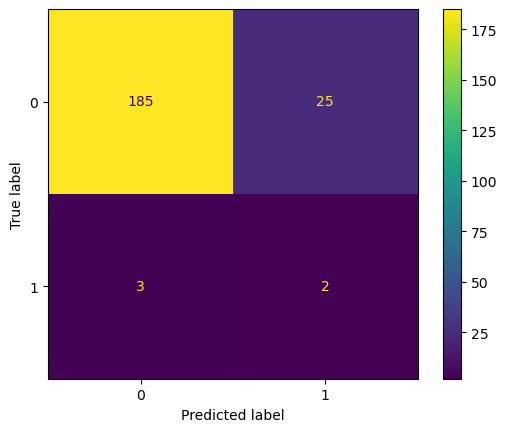

In [99]:
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y1_test, preds2);

In [100]:
# print the r2 value 
print("Logisitic Classifier: ", log_reg_2.score(X1_resampled, y1_resampled))

Logisitic Classifier:  0.8420634920634921


In [101]:
print("\nClassification Report (Logistic Regression):")
print(classification_report(y1_test, preds2, zero_division=0))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       210
           1       0.07      0.40      0.12         5

    accuracy                           0.87       215
   macro avg       0.53      0.64      0.53       215
weighted avg       0.96      0.87      0.91       215



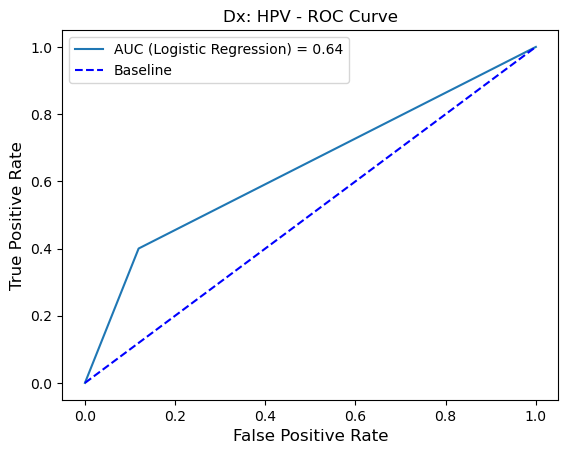

In [102]:
y_test_int = y1_test
auc_lr = roc_auc_score(y_test_int, preds2)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_int, preds2)

plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Dx: HPV - ROC Curve', size=12)
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.legend();

In [103]:
print(log_reg_2.coef_, log_reg_2.intercept_)

[[-6.49578836  1.21296535  2.93655991 -7.77732933 22.19237754  0.36673651
   2.33001829]] [-1.97790018]
